In [9]:
"""
Credits to: Stuart Jamieson
https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/
"""

'\nCredits to: Stuart Jamieson\nhttps://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/\n'

In [13]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]

In [7]:
df = pd.read_csv('./data/EURUSD.csv',sep='\t', index_col='Date')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df = df.resample('W').last()
series = df['Price']

In [8]:
series

Date
2000-01-09    1.0292
2000-01-16    1.0128
2000-01-23    1.0091
2000-01-30    0.9750
2000-02-06    0.9828
               ...  
2019-02-03    1.1456
2019-02-10    1.1330
2019-02-17    1.1295
2019-02-24    1.1343
2019-03-03    1.1377
Freq: W-SUN, Name: Price, Length: 1000, dtype: float64

Hodrick-Prescott Filter: The HP filter is a technique commonly used with macro-economic series that have a trend (long-term movements), business cycle and irregular parts (short-term fluctuations). It constructs the trend component by solving an optimisation problem. It aims to form the smoothest trend estimate that minimises the squared distances to the original series. In other words, it has to find equilibrium between the smoothness of the trend and its closeness to the original.

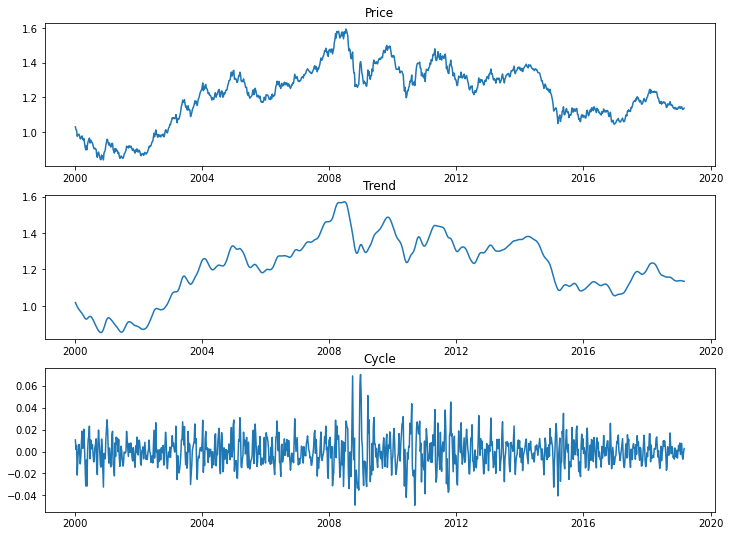

In [10]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

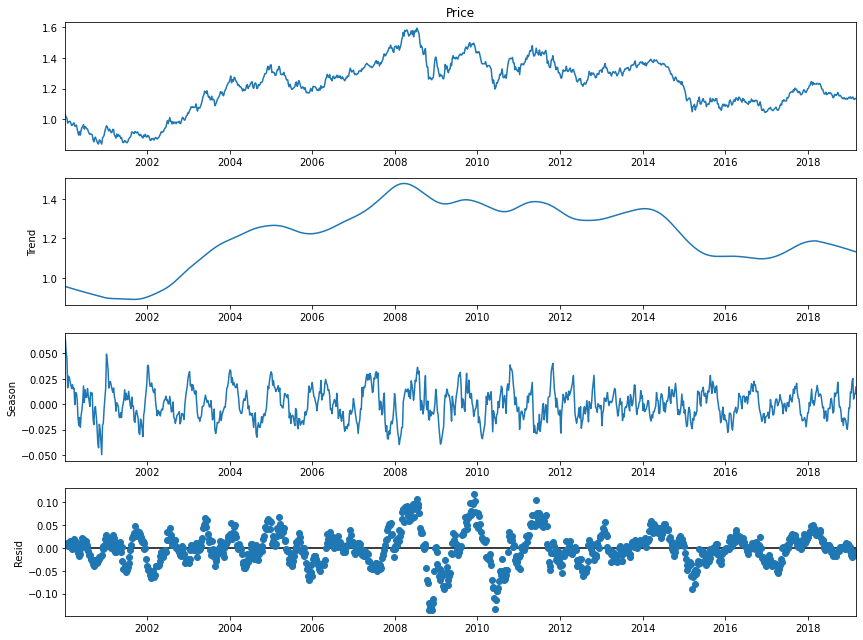

In [11]:
# STL decomposition
result = STL(series).fit()
chart = result.plot()
plt.show()

Baseline model

Test RMSE: 0.01304


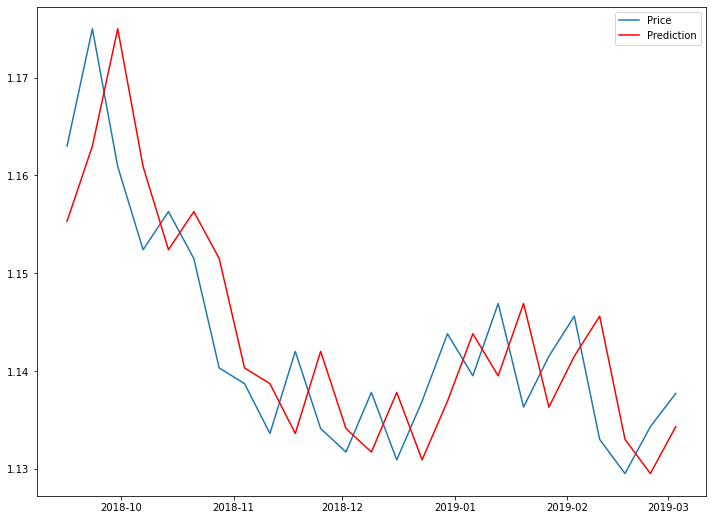

In [14]:
predictions = series.shift(1).dropna() # shifting the last price forward one week
test_score = np.sqrt(mean_squared_error(series[int(len(series) * 0.7)+1:], predictions.iloc[int(len(series) * 0.7):]))
print('Test RMSE: %.5f' % test_score)
plt.plot(series.iloc[-25:], label='Price')
plt.plot(predictions[-25:], color='red', label='Prediction')
plt.legend()
plt.show()

/Users/w1ufxk2/miniconda3/envs/stl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


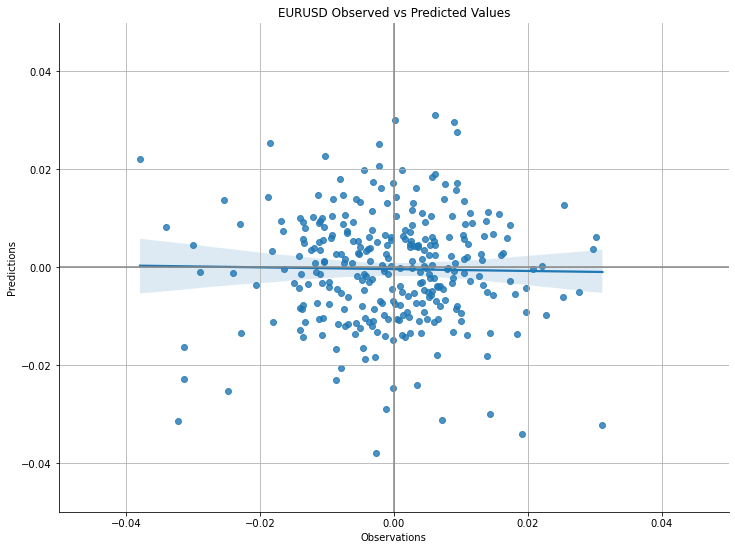

The MAE is 0.0125


In [15]:
fig, ax = plt.subplots()
ax = sns.regplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            predictions.iloc[-int(len(series) * 0.3):].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - predictions.iloc[-int(len(series) * 0.3):].pct_change()).mean(),4)
print(f'The MAE is {mae}')

In [16]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), predictions.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 48.49%


Autoregressive model

Test MSE: 0.01310


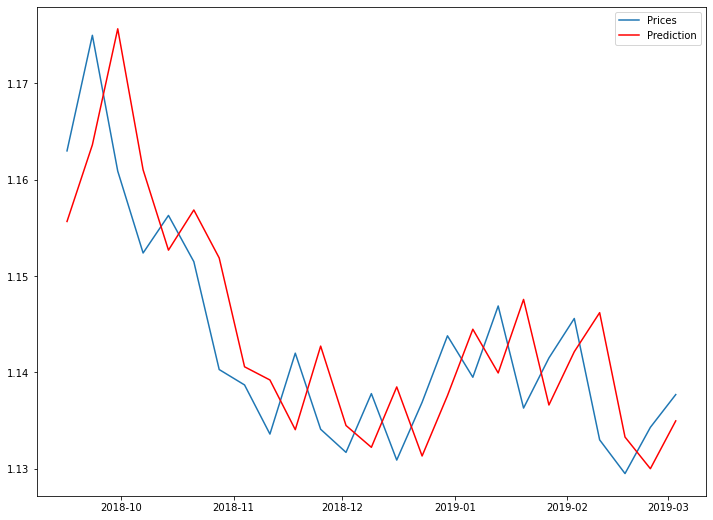

In [24]:
from statsmodels.tsa.ar_model import AutoReg

historic = series.iloc[:int(len(series) * 0.7)].to_list()
test = series.iloc[int(len(series) * 0.7):]

predictions = []

for i in range(len(test)):

    model = AutoReg(historic, 2)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test[i])
    
predictions = pd.Series(predictions, index=test.index)
    
test_score = np.sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.5f' % test_score)
# plot results
plt.plot(test.iloc[-25:], label='Prices')
plt.plot(predictions.iloc[-25:], color='red', label='Prediction')
plt.legend()
plt.show()

/Users/w1ufxk2/miniconda3/envs/stl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


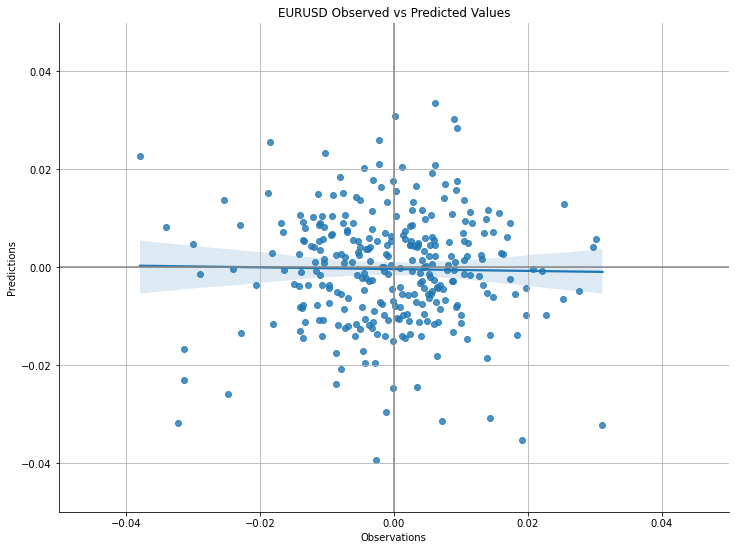

The MAE is 0.0126602718


In [25]:
fig, ax = plt.subplots()
ax = sns.regplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            predictions.iloc[-int(len(series) * 0.3):].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()
mae = round(abs(test.pct_change() - predictions.pct_change()).mean(),10)
print(f'The MAE is {mae}')

In [26]:
price_pred = pd.concat([test.pct_change(), predictions.pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 48.49%


Decomposition Model

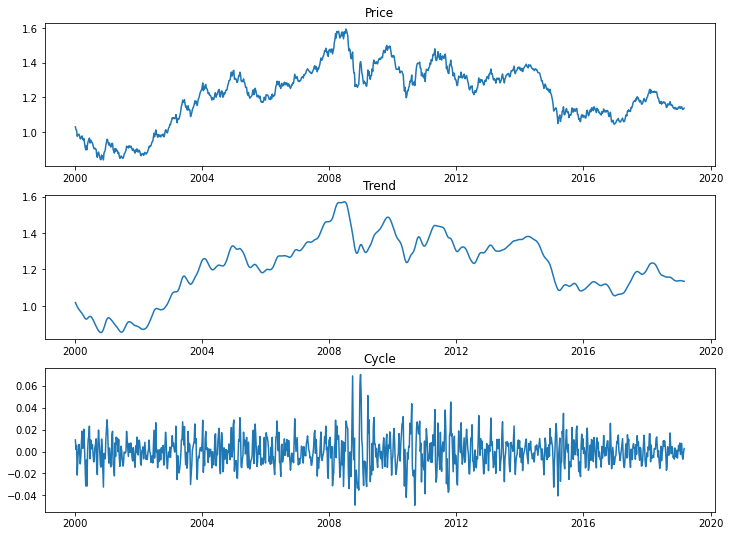

In [27]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

Test for trend MSE: 0.0007330865937228562


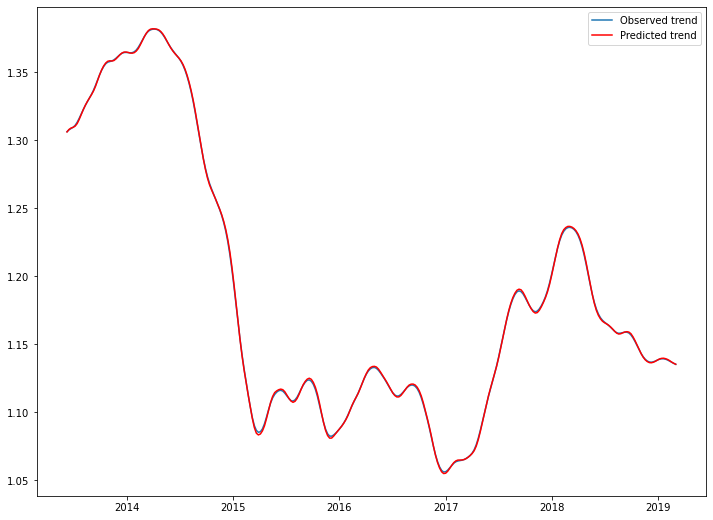

Test for cycle MSE: 0.009633012751606796


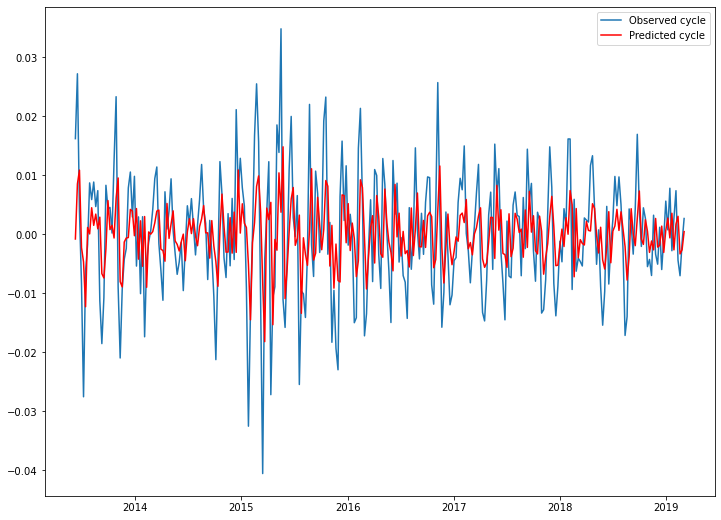

In [28]:
component_dict = {'cycle': cycle, 'trend': trend}

prediction_results = []

for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]

    predictions = []

    for i in range(len(test)):

        model = AutoReg(historic, 2)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

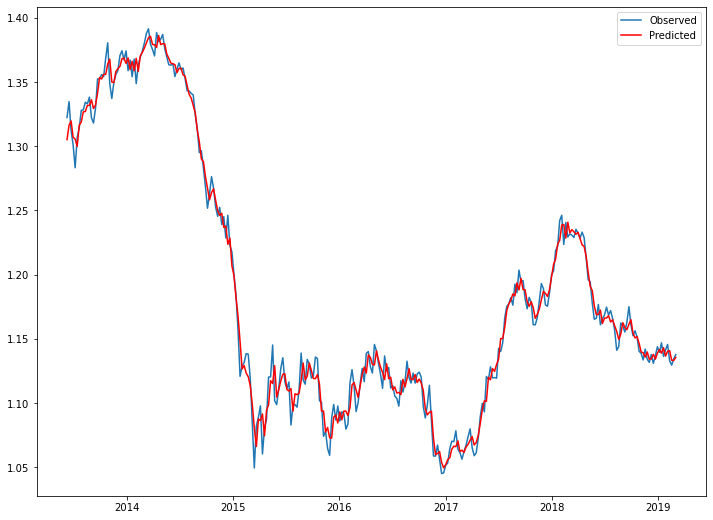

RMSE: 0.009501264724098988


In [29]:
# Recompose in an additive manner
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

/Users/w1ufxk2/miniconda3/envs/stl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


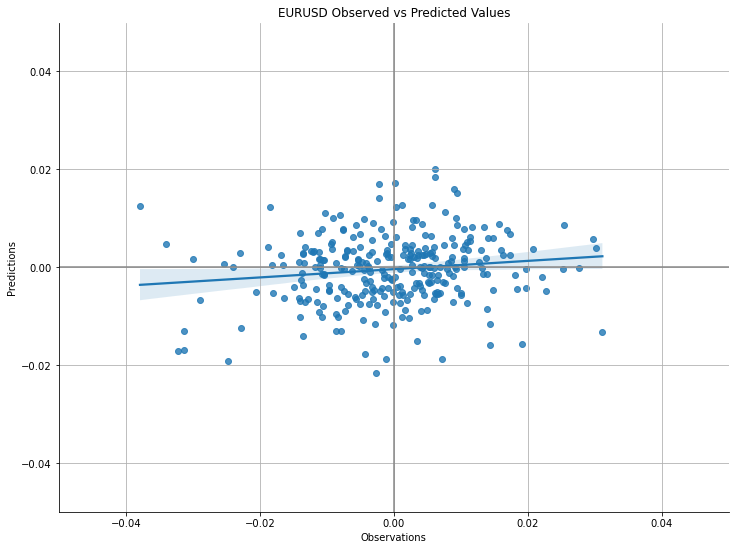

The MAE is 0.0096129408


In [30]:
fig, ax = plt.subplots()
ax = sns.regplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change())

plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

In [31]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(),recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['recomposed_preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 53.51%


STL Decomposition

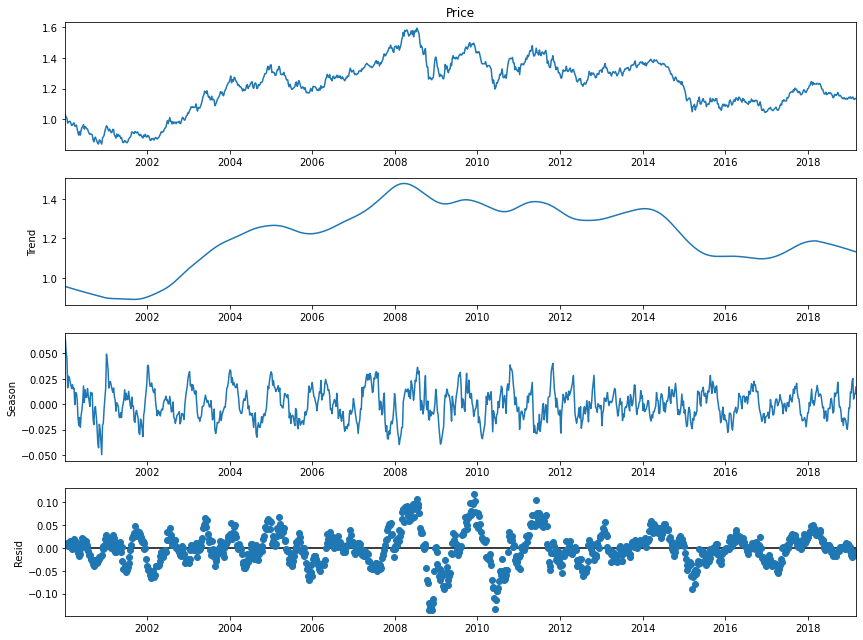

In [32]:
result = STL(series).fit()
result.plot()
plt.show()

In [33]:
result.seasonal.head()

Date
2000-01-09    0.064431
2000-01-16    0.051409
2000-01-23    0.045596
2000-01-30    0.016182
2000-02-06    0.027625
Freq: W-SUN, Name: season, dtype: float64

Test for seasonal MSE: 0.006682285801866828


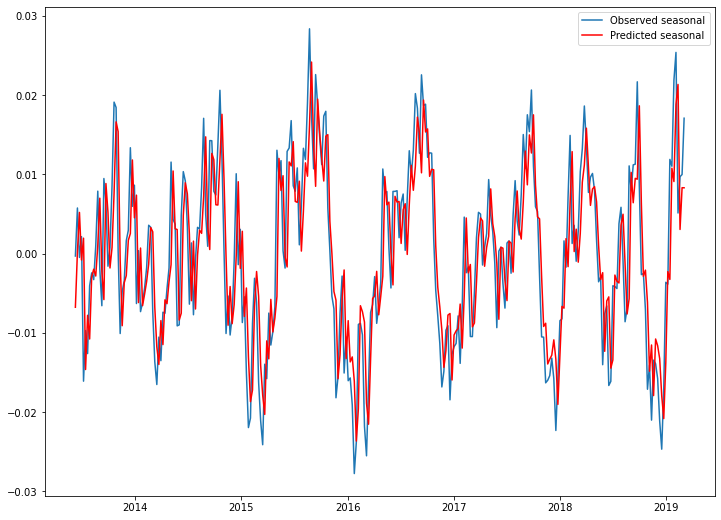

Test for trend MSE: 7.829691520729971e-05


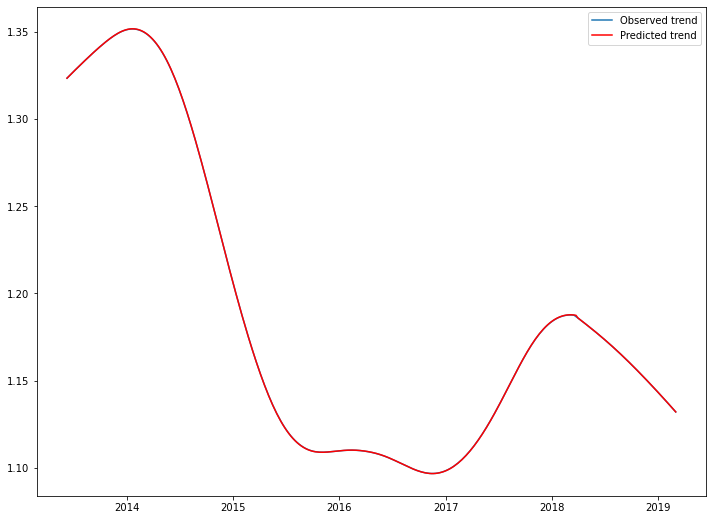

Test for residual MSE: 0.009777596621717288


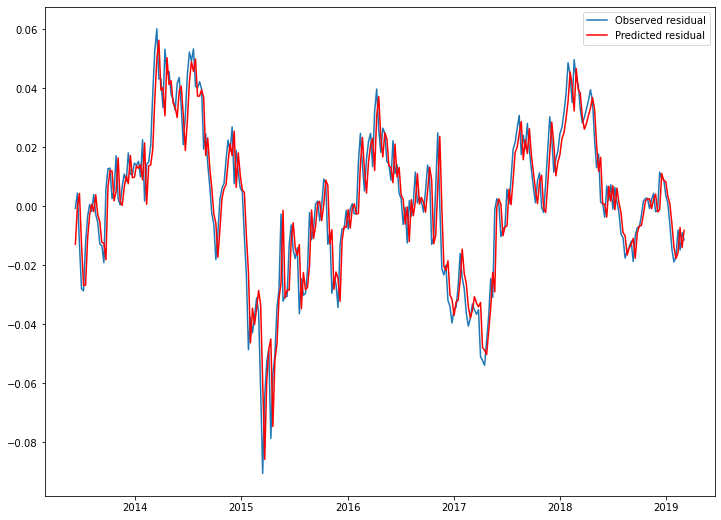

In [35]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}

prediction_results = []

for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]

    predictions = []

    for i in range(len(test)):

        model = AutoReg(historic, 2)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

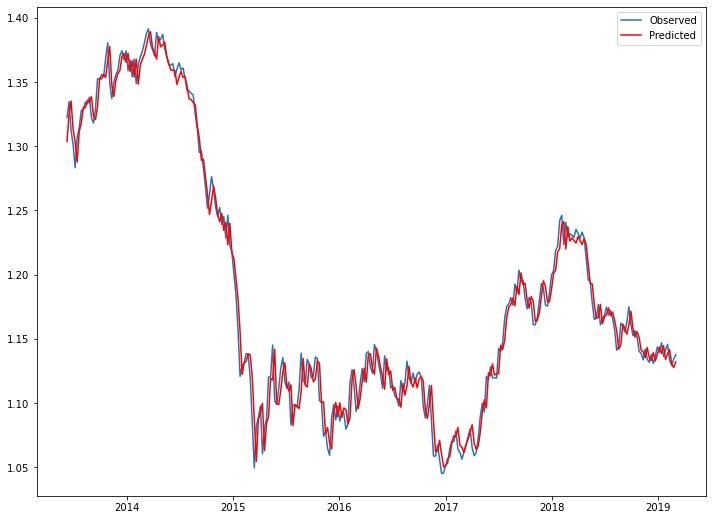

RMSE: 0.012469347327887983


In [36]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()

test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

/Users/w1ufxk2/miniconda3/envs/stl/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


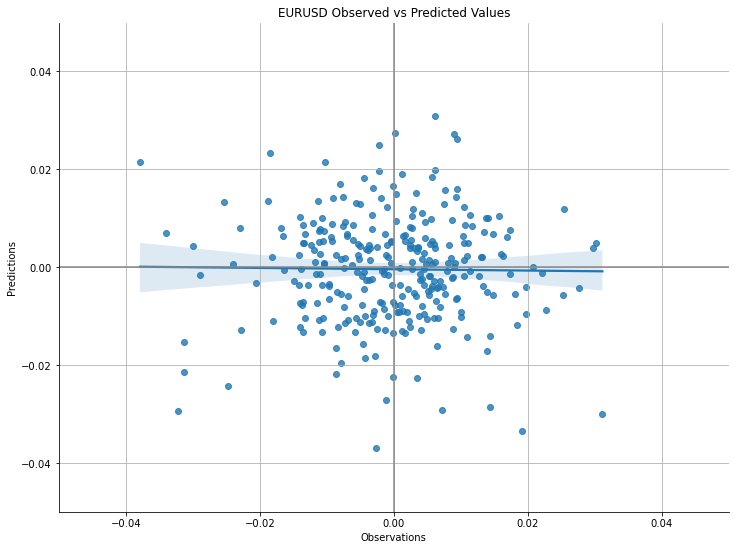

The MAE is 0.0121582935


In [37]:
fig, ax = plt.subplots()
ax = sns.regplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change(), )
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.title('EURUSD Observed vs Predicted Values')
ax.grid(True, which='both')
ax.axhline(y=0, color='#888888')
ax.axvline(x=0, color='#888888')
sns.despine(ax=ax, offset=0)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.show()

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

In [38]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 49.16%


In [ ]:
The outcome of the decomposition method used hugely affects the final predictions. The AR model parameters were not estimated using future observations, nor was the STL Decomposition so its not a huge shock that in this instance it didn’t provide a magic bullet to solve our prediction problem.


In [ ]:
# Note to myself: This implementation introduces look-forward bias. The decomposition should have been done on the training set and not on the entire time series.